In [1]:
import onnx
import torch
import numpy as np
import pandas as pd  
import copy
import pprint
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

from torch import nn

import sys
sys.path.append('/Users/khoanguyen-cp/gmu/network_properties')

from models.test_models import ProphecyPaperNetwork, TestModel
from models.acasxu_1_1 import Acasxu1_1
from models.utils import attach_relu_activation_hook, attach_layer_output_hook, get_layers_info
from models.utils import turn_bool_activation_to_int, turn_bool_activation_to_str

from algorithms.decision_procedure import MarabouCoreDP

Instructions for updating:
non-resource variables are not supported in the long term


## 1. Prepare model and data

In [74]:
model = Acasxu1_1()
model.load_state_dict(torch.load('../models/acasxu_1_1.pt'))

<All keys matched successfully>

In [3]:
acas_train = np.empty([384221,5],dtype=float)
acas_train_labels = np.zeros(384221,dtype=int)

def read_inputs_from_file(inputFile):
  global acas_train, acas_train_labels, num
  with open(inputFile) as f:
    lines = f.readlines()
    print(len(lines), "examples")
    acas_train = np.empty([len(lines),5],dtype=float)
    acas_train_labels = np.zeros(len(lines),dtype=int)

    for l in range(len(lines)):
      # This is to remove the useless 1 at the start of each string. Not sure why that's there.
      k = [float(stringIn) for stringIn in lines[l].split(',')] 
      
      # acas_train[l+num] = np.zeros(5,dtype=float) 
      # we're asuming that everything is 2D for now. The 1 is just to keep numpy happy.
      if len(k) > 5:
        lab = int(k[5])
        #if ((lab == 0) or (lab == 2)):
        #  lab = 0
        #else:
        #  lab = 1
        acas_train_labels[l+num] = lab

      count = 0
      for i in range(0,5):
        #print(count)
        acas_train[l+num][i] = k[i]
        #print(k[i])

In [4]:
num = 0
read_inputs_from_file('../datasets/clusterinACAS_0_shrt.csv')
print(acas_train.shape)
print(acas_train_labels.shape)
print(acas_train[:5])
print(acas_train_labels[:5])

384221 examples
(384221, 5)
(384221,)
[[-0.320142 -0.5      -0.5      -0.5      -0.5     ]
 [-0.295234 -0.5      -0.5      -0.5      -0.5     ]
 [-0.240207 -0.5      -0.5      -0.5      -0.5     ]
 [-0.208943 -0.5      -0.5      -0.5      -0.5     ]
 [-0.183636 -0.5      -0.5      -0.5      -0.5     ]]
[3 1 0 0 0]


In [5]:
def create_df(inputs, predicted_labels, true_labels, activation_signature):
  data = []
  for index, input_data in enumerate(inputs):
    data_point = { 
      "input": input_data, 
      "true_label": true_labels[index], 
      "predicted_label": predicted_labels[index].item(),
    }
#     data_point_full_signature = {} 
#     for name, layer_activation in activation_signature.items():
#       data_point[name] = json.dumps(layer_activation[index])
#       data_point_full_signature[name] = layer_activation[index]
      
#     data_point['full_signature_str'] = json.dumps(data_point_full_signature)
    data.append(data_point)
  return pd.DataFrame(data)

_act_handles, activation_signature = attach_relu_activation_hook(model)  
outputs = model(torch.tensor(acas_train, dtype=torch.float32))
predicted_labels = torch.argmin(outputs, dim=1)
activation_signature = turn_bool_activation_to_int(activation_signature, to_list=True)
df = create_df(acas_train, predicted_labels, acas_train_labels, activation_signature)
df.head(10)

,input,true_label,predicted_label
0,"[-0.320142, -0.5, -0.5, -0.5, -0.5]",3,3
1,"[-0.295234, -0.5, -0.5, -0.5, -0.5]",1,1
2,"[-0.240207, -0.5, -0.5, -0.5, -0.5]",0,0
3,"[-0.208943, -0.5, -0.5, -0.5, -0.5]",0,0
4,"[-0.183636, -0.5, -0.5, -0.5, -0.5]",0,0
5,"[-0.10156, -0.5, -0.5, -0.5, -0.5]",0,0
6,"[-0.000732, -0.5, -0.5, -0.5, -0.5]",0,0
7,"[0.100096, -0.5, -0.5, -0.5, -0.5]",0,0
8,"[0.200941, -0.5, -0.5, -0.5, -0.5]",0,0
9,"[0.301769, -0.5, -0.5, -0.5, -0.5]",0,0


## 2. Sampling

In [6]:
def initialize_activation_counts(model, sample):
  _act_handles, activation_signature = attach_relu_activation_hook(model)  
  X = torch.tensor(sample, dtype=torch.float)
  _logits = model(X)
  
  activation_signature = turn_bool_activation_to_int(activation_signature)
  for layer_name, activations in activation_signature.items():
    activation_signature[layer_name] = np.zeros_like(activations[0])
    
  return activation_signature.copy()

In [7]:
y_class = 0

# get all data points with predicted class y
class_df = df[df['predicted_label'] == y_class]

# ranges = []
# for i in range(5):
#   min_val = class_df['input'].apply(lambda x: x[i]).min()
#   max_val = class_df['input'].apply(lambda x: x[i]).max()
#   ranges.append([min_val, max_val])

# # initialize the activation counts dictionary using the activation signature dictionary
# # cus they should have the same structure 
# activation_counts = initialize_activation_counts(model, [[0.62, 0.1, 0.2, 0.47, -0.48]])  

# # calculate activation probability of each neuron in the network
# for index, row in class_df.iterrows():
#   full_signature = json.loads(row['full_signature_str'])
#   for layer, activation in full_signature.items():
#     # update activation count
#     activation_counts[layer] += np.array(activation)
    
# activation_probabilities = {}
# for layer, neuron_act_counts in activation_counts.items():
#   activation_probabilities[layer] = neuron_act_counts/len(class_df)
    
# np.set_printoptions(formatter={'float': '{: 0.8f}'.format})
# activation_probabilities

In [8]:
# candidate = activation_probabilities.copy()
# for layer, activation_probs in candidate.items():
#   new_activation = [
#     "ON" if prob == 1 else ("OFF" if prob == 0 else "--")
#     for prob in activation_probs
#   ]
#   candidate[layer] = new_activation
# print(candidate)

In [9]:
specification_for_classes = {
  0: [(np.array([[-1, 1, 0, 0, 0]]), np.array([0])),
      (np.array([[-1, 0, 1, 0, 0]]), np.array([0])),
      (np.array([[-1, 0, 0, 1, 0]]), np.array([0])),
      (np.array([[-1, 0, 0, 0, 1]]), np.array([0]))],
  
  1: [(np.array([[1, -1, 0, 0, 0]]), np.array([0])),
      (np.array([[0, -1, 1, 0, 0]]), np.array([0])),
      (np.array([[0, -1, 0, 1, 0]]), np.array([0])),
      (np.array([[0, -1, 0, 0, 1]]), np.array([0]))],
  
  2: [(np.array([[1, 0, -1, 0, 0]]), np.array([0])),
      (np.array([[0, 1, -1, 0, 0]]), np.array([0])),
      (np.array([[0, 0, -1, 1, 0]]), np.array([0])),
      (np.array([[0, 0, -1, 0, 1]]), np.array([0]))],
  
  3: [(np.array([[1, 0, 0, -1, 0]]), np.array([0])),
      (np.array([[0, 1, 0, -1, 0]]), np.array([0])),
      (np.array([[0, 0, 1, -1, 0]]), np.array([0])),
      (np.array([[0, 0, 0, -1, 1]]), np.array([0]))],
  
  4: [(np.array([[1, 0, 0, 0, -1]]), np.array([0])),
      (np.array([[0, 1, 0, 0, -1]]), np.array([0])),
      (np.array([[0, 0, 1, 0, -1]]), np.array([0])),
      (np.array([[0, 0, 0, 1, -1]]), np.array([0]))],
}

In [10]:
# dp = MarabouCoreDP()
# dp.solve(candidate, model, ranges, specification_for_classes[y_class])

In [11]:
# test_class_df = df[df['predicted_label'] == 0]
# grouped_samples = test_class_df.groupby('full_signature_str').size().reset_index(name='Count')
# sorted_groups = grouped_samples.sort_values('Count', ascending=False)
# sorted_groups

In [12]:
# test_signature = sorted_groups.loc[110619]['full_signature_str']
# test_signature_count = sorted_groups.loc[110619]['Count']

In [13]:
class_0 = df[df['predicted_label'] == 0]
indices = class_0.index.tolist()
input_features = np.vstack(np.array(class_0['input']))
# data_for_clustering = {'id': indices }
# num_of_features = 5 

# for feature in range(num_of_features):
#   data_for_clustering[f"x{feature}"] = input_features[:, feature]
  
# clustering_df = pd.DataFrame(data_for_clustering)  
# clustering_df

In [14]:
input_features.shape # 5 featuers

(280802, 5)

(280802, 3)


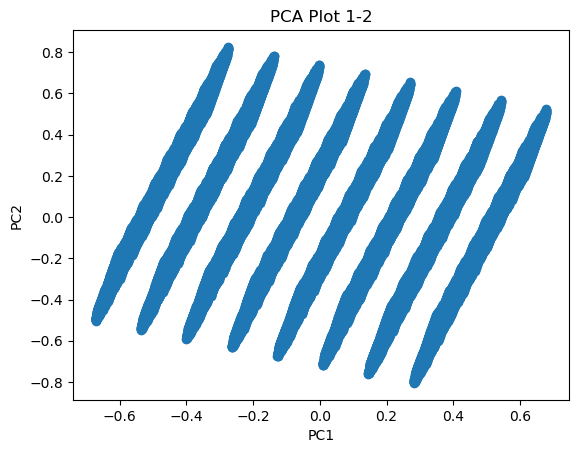

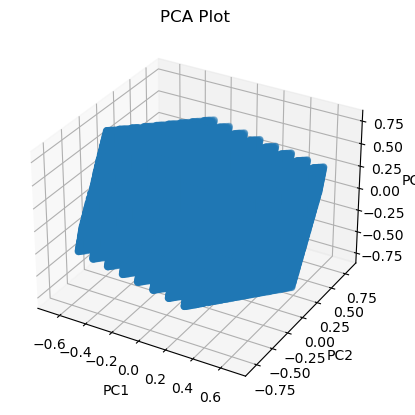

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

X = input_features # Sample data with 5 features

# Perform PCA
pca = PCA(n_components=3)  # Specify the number of components to keep
X_pca = pca.fit_transform(X)
print(X_pca.shape)

# Plot the results
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot 1-2')
plt.show()

# Plot the results in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA Plot')
plt.show()

### Birch clustering

In [86]:
from numpy import unique
from numpy import where
from sklearn.cluster import Birch
from matplotlib import pyplot

# Generate some sample data
X = input_features

birch = Birch(n_clusters=8, threshold=0.1)
labels = birch.fit_predict(X)

In [87]:
labels

array([7, 7, 7, ..., 6, 2, 2])

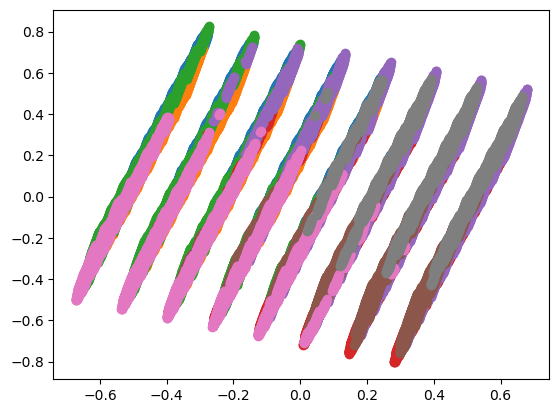

In [88]:
for cluster in range(8):
  # get row indexes for samples with this cluster
  row_ix = where(labels == cluster)
  pyplot.scatter(X_pca[row_ix, 0], X_pca[row_ix, 1])
  
  # create scatter of these samples
  # pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show the plot
pyplot.show()

In [91]:
labels == 1

array([False, False, False, ..., False, False, False])

In [89]:
# Set the number of samples to be extracted from each cluster
num_samples_per_cluster = 2000

# Sample data from each cluster
sampled_data = []
unique_labels = np.unique(labels)
for label in unique_labels:
    cluster_samples = X[labels == label]
    sampled_cluster_samples = cluster_samples[:num_samples_per_cluster]
    sampled_data.extend(sampled_cluster_samples)

# Convert the sampled data to a numpy array
sampled_data = np.array(sampled_data)
sampled_data.shape

(16000, 5)

In [ ]:
_act_handles, activation_signature = attach_relu_activation_hook(model)
activation_counts_template = initialize_activation_counts(model, [[0.62, 0.1, 0.2, 0.47, -0.48]])  
cluster_outputs = model(torch.tensor(sampled_data, dtype=torch.float32))
activation_signature = turn_bool_activation_to_int(activation_signature, to_list=True)
print(cluster_outputs.shape)
print(len(activation_signature['relu0']))

In [ ]:
import copy

def find_candidate_for_cluster(cluster):
  activation_counts = copy.deepcopy(activation_counts_template)

  for layer, counts in activation_counts.items():
    start_id = cluster*2000
    end_id = start_id + 2000
    cluster_activations = activation_signature[layer][start_id:end_id]
    
    for activation in cluster_activations:
      counts += np.array(activation)
      
  cluster_activation_probabilities = {}
  for layer, neuron_act_counts in activation_counts.items():
    cluster_activation_probabilities[layer] = neuron_act_counts/2000

  cluster_candidate = cluster_activation_probabilities.copy()
  for layer, activation_probs in cluster_candidate.items():
    new_activation = [
      "ON" if prob == 1 else ("OFF" if prob == 0 else "--")
      for prob in activation_probs
    ]
    cluster_candidate[layer] = new_activation
  return cluster_candidate

In [ ]:
str(find_candidate_for_cluster(3))

In [ ]:
candidates = []
dp = MarabouCoreDP()
model = Acasxu1_1()
model.load_state_dict(torch.load('../models/acasxu_1_1.pt'))

for cluster in range(8):
  candidates.append(find_candidate_for_cluster(cluster))

for cluster, candidate in enumerate(candidates): 
  print(f"===== CANDIDATE FOR CLUSTER {cluster} =====")
  print(candidate)
  start_id = cluster*2000
  end_id = start_id + 2000
  cluster_samples = sampled_data[start_id:end_id]
  sample_mins = np.min(cluster_samples, axis=0)
  sample_maxs = np.max(cluster_samples, axis=0)
  ranges = [[sample_mins[i], sample_maxs[i]] for i in range(5)]
  res = dp.solve(candidate, model, ranges, specification_for_classes[0])
  print(res)
  

### DBSCAN

In [71]:
# dbscan clustering
from numpy import unique
from numpy import where
from sklearn.cluster import DBSCAN
from matplotlib import pyplot

X = input_features
dbscan = DBSCAN(eps=0.142, min_samples=10)

# fit model and predict clusters
yhat = dbscan.fit_predict(X)
unique(yhat).shape

(30,)

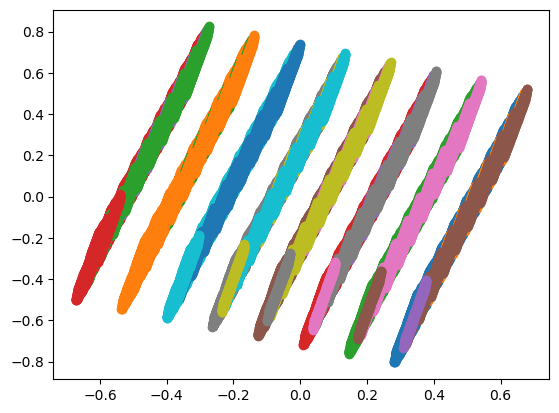

In [72]:
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster

for cluster in clusters:
  row_ix = where(yhat == cluster)
  pyplot.scatter(X_pca[row_ix, 0], X_pca[row_ix, 1])
  
# show the plot
pyplot.show()

In [83]:
# Set the number of samples to be extracted from each cluster
num_samples_per_cluster = 2000

# Sample data from each cluster
sampled_data = []
unique_labels = np.unique(labels)
for label in unique_labels:
    cluster_samples = X[labels == label]
    sampled_cluster_samples = cluster_samples[:num_samples_per_cluster]
    sampled_data.extend(sampled_cluster_samples)

# Convert the sampled data to a numpy array
sampled_data = np.array(sampled_data)
sampled_data.shape

_act_handles, activation_signature = attach_relu_activation_hook(model)
activation_counts_template = initialize_activation_counts(model, [[0.62, 0.1, 0.2, 0.47, -0.48]])  
cluster_outputs = model(torch.tensor(sampled_data, dtype=torch.float32))
activation_signature = turn_bool_activation_to_int(activation_signature, to_list=True)
print(cluster_outputs.shape)
print(len(activation_signature['relu0']))

def find_candidate_for_cluster(cluster):
  activation_counts = copy.deepcopy(activation_counts_template)

  for layer, counts in activation_counts.items():
    start_id = cluster*int(len(sampled_data)/len(clusters))
    end_id = start_id + int(len(sampled_data)/len(clusters))
    cluster_activations = activation_signature[layer][start_id:end_id]
    
    for activation in cluster_activations:
      counts += np.array(activation)
      
  cluster_activation_probabilities = {}
  for layer, neuron_act_counts in activation_counts.items():
    cluster_activation_probabilities[layer] = neuron_act_counts/int(len(sampled_data)/len(clusters))

  cluster_candidate = cluster_activation_probabilities.copy()
  for layer, activation_probs in cluster_candidate.items():
    new_activation = [
      "ON" if prob == 1 else ("OFF" if prob == 0 else "--")
      for prob in activation_probs
    ]
    cluster_candidate[layer] = new_activation
  return cluster_candidate

torch.Size([16000, 5])
16000


In [84]:
candidates = []
dp = MarabouCoreDP()
model = Acasxu1_1()
model.load_state_dict(torch.load('../models/acasxu_1_1.pt'))

for cluster in clusters:
  candidates.append(find_candidate_for_cluster(cluster))
  
candidates_strs = set([str(can) for can in candidates])
len(candidates_strs)

30

In [85]:
candidates_strs

{"{'relu0': ['--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', 'OFF', '--', '--', 'ON', '--', 'ON', 'ON', 'ON', 'OFF', 'OFF', 'ON', '--', '--', 'ON', 'OFF', '--', '--', 'ON', 'ON', '--', '--', '--', '--', '--', 'OFF', '--'], 'relu1': ['OFF', 'OFF', '--', '--', 'OFF', 'OFF', '--', '--', '--', '--', 'OFF', '--', 'OFF', 'OFF', '--', '--', '--', '--', 'OFF', 'OFF', '--', '--', '--', 'OFF', 'OFF', 'OFF', 'OFF', 'OFF', 'OFF', 'ON', '--', '--', '--', '--', 'ON', 'OFF', 'OFF', 'OFF', 'OFF', '--', 'OFF', '--', 'OFF', 'OFF', '--', '--', 'OFF', 'OFF', '--', '--'], 'relu2': ['--', '--', '--', '--', '--', '--', '--', '--', '--', 'OFF', '--', '--', '--', '--', 'OFF', '--', '--', 'ON', 'OFF', 'OFF', '--', 'OFF', '--', '--', 'OFF', '--', '--', 'OFF', 'OFF', '--', '--', '--', 'OFF', 'OFF', '--', '--', '--', '--', '--', 'OFF', '--', '--', '--', 'OFF', '--', '--', '--', 'OFF', '--', '--'], 'relu3': ['OFF', 'OFF'